# Correlation analysis: is Bitcoin related to the market?

_Created by:_ Davide Burba, February 2020

_Summary:_ In this notebook we explore the correlations between Bitcoin and the S&P 500 Index, and we make a comparison with Gold.

In [1]:
import pandas as pd
import numpy as np

# utils
import sys
sys.path.append("./src/correlation_analysis")
from correlation import *
from data_manipulation import *
from plot import *

# plotting
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
register_matplotlib_converters()
sns.set()

# Data import

We consider the daily time series of Bitcoin (BTC), S&P Index (SP500) and Gold (GLD). 

The data can be downloaded from:
- SP500: https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD
- Bitcoin: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
- Gold: https://finance.yahoo.com/quote/GLD/history?p=GLD

In [2]:
sp = pd.read_csv("data/SP_500.csv")
btc = pd.read_csv("data/BTC-USD.csv")

# fix date type
sp.Date = sp.Date.astype("datetime64")
btc.Date = btc.Date.astype("datetime64")

In [3]:
# for reproducibility
np.random.seed(23)
sp = sp[sp.Date <= '2020-01-16 00:00:00']
btc = btc[btc.Date <= '2020-01-16 00:00:00']

# Data preparation: build weekly time series

Based on daily data we compute 5  weekly time series, considering each day in Monday,..,Friday as last day of the week.
This allows for a consistency check: if some properties are shown only in some of the 5 time series, they are probably due by chance.

We also compute volume, range and trend features: 

- Volume is the sum of the volume of the previous week

- Range is computed as the highest minus the lowest price of the week; we (improperly) refer to it as "volatility"

- Trend feature corresponds to the linear coefficient fitted in the last 5 days for the time series

We store the 5 corresponding dataframe on a list.

In [4]:
# merge data
df = pd.merge(sp,btc, on = "Date", suffixes = ("SP500","BTC"))
df.index = df.Date
df = df.drop(columns = "Date")

# build weekly_data
weekly_data = build_weekly_data(df)

## Categorisation of data

In [6]:
weekly_data[0].SP500_weekly_change.apply(abs).describe()

count    251.000000
mean      29.206168
std       33.177416
min        0.050049
25%        8.175049
50%       18.260010
75%       36.380004
max      203.709961
Name: SP500_weekly_change, dtype: float64

In [5]:
weekly_data[0].SP500_weekly_range.describe()

count    251.000000
mean      60.199677
std       39.466925
min       14.469971
25%       34.349853
50%       48.679932
75%       71.789917
max      236.459961
Name: SP500_weekly_range, dtype: float64

In [165]:
# 25% quantile of weekly range, 75% quantile of weekly range, 
# 50% quantile of weekly change and 75% quantile of weekly change
t1, t2, t3, t4 = 34, 70, 18, 36
weekly_data_day = weekly_data[0]

In [166]:
weekly_data_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2014-10-06 to 2020-01-13
Data columns (total 8 columns):
CloseSP500_weekly_pct_change    251 non-null float64
SP500_weekly_range              251 non-null float64
SP500_weekly_trend              251 non-null float64
SP500_weekly_change             251 non-null float64
CloseBTC_weekly_pct_change      251 non-null float64
VolumeBTC_weekly_pct_change     251 non-null float64
BTC_weekly_range                251 non-null float64
BTC_weekly_return               251 non-null float64
dtypes: float64(8)
memory usage: 27.6 KB


In [ ]:
def categorisation(t1, t2, t3, t4, weekly_data_day):
    """Split data into different categories and store their indices"""
    index_dic = {}
    index_dic['stable'] = weekly_data_day[weekly_data_day.SP500_weekly_range < t1].index
    index_dic['unstable'] = weekly_data_day[(weekly_data_day.SP500_weekly_range > t2)
                                            & (weekly_data_day.SP500_weekly_change.apply(abs) < t3)].index
    index_dic['trend up'] = weekly_data_day[(weekly_data_day.SP500_weekly_range > t2)
                                            & (weekly_data_day.SP500_weekly_change > 0)
                                            & (weekly_data_day.SP500_weekly_change.apply(abs) > t4)].index
    index_dic['trend down'] = weekly_data_day[(weekly_data_day.SP500_weekly_range > t2)
                                            & (weekly_data_day.SP500_weekly_change < 0)
                                            & (weekly_data_day.SP500_weekly_change.apply(abs) > t4)].index
    return index_dic

In [ ]:
def draw_samples(t1, t2, t3, t4, weekly_data_day, df, num_samples):
    """Plot the num_samples from different catogories"""
    index_dic = categorisation(t1, t2, t3, t4, weekly_data_day)
    for category, dates in index_dic.items():
        if len(dates) == 0:
            raise ValueError("Catagory {} is empty".format(category))
        fig, axs = plt.subplots(1, num_samples, figsize=(15,5))
        for num, index in enumerate(np.random.randint(len(dates), size=num_samples)):
            data = df[df.index <= dates[index]].sort_index().CloseSP500.tail(5)
            axs[num].plot(data,
                          label='Close s&p 500 \n' + "Range: {:0.1f}, \nChange(abs): {:0.1f}".format(weekly_data_day.SP500_weekly_range.loc[dates[index]],
                                                                                                     weekly_data_day.SP500_weekly_change.apply(abs).loc[dates[index]]))
            bottom, _ = axs[num].get_ylim()
            axs[num].set_ylim(bottom=bottom, top = bottom + 150)
            axs[num].set_xticks([])
            axs[num].legend()
        fig.suptitle(category + " (number of data: {})".format(len(dates)))
        plt.show()

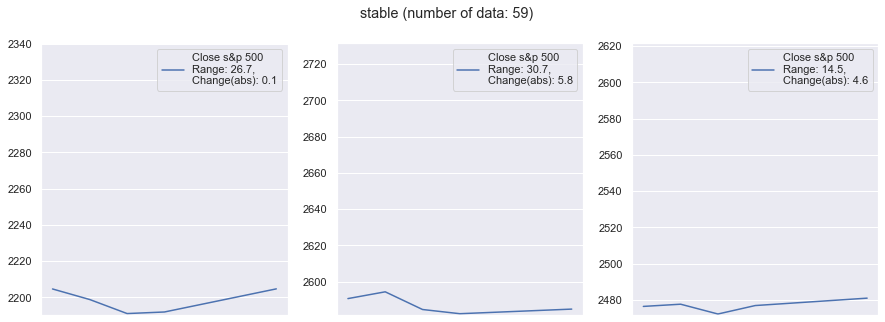

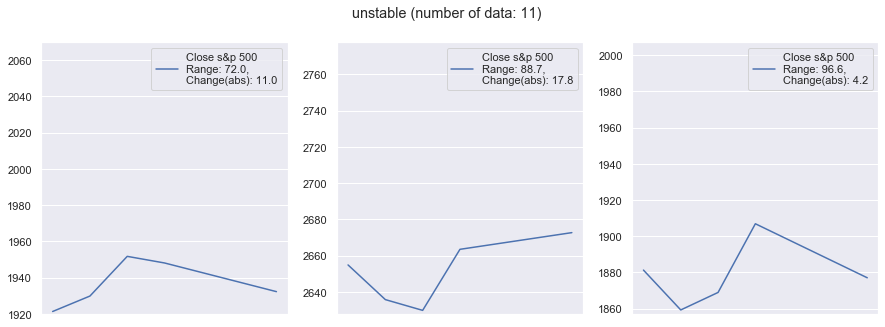

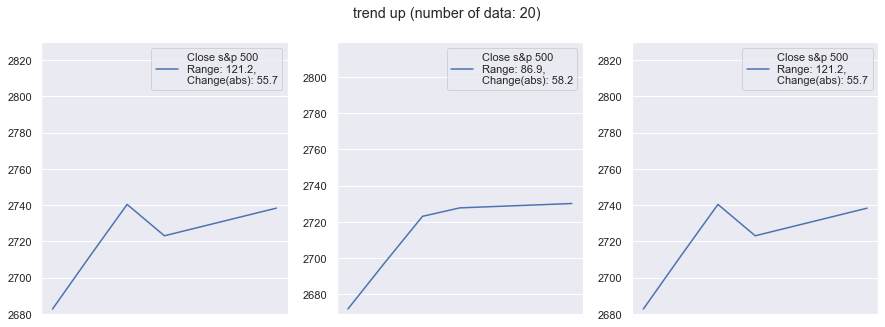

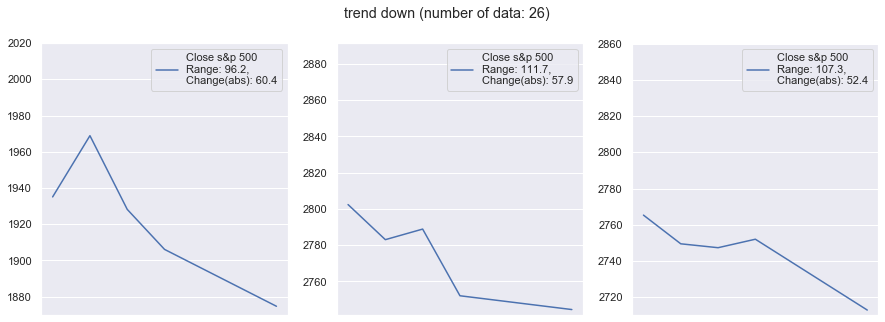

In [167]:
draw_samples(t1, t2, t3, t4, weekly_data_day, df, num_samples=3);

In [162]:
weekly_data[0].BTC_weekly_return.describe()

count     251.000000
mean       54.717378
std       625.412522
min     -3151.029785
25%       -39.098007
50%         3.696000
75%        83.072021
max      5020.100586
Name: BTC_weekly_return, dtype: float64

## Distribution of Bitcoin return

In [61]:
from sklearn.linear_model import LinearRegression

In [184]:
def catagorised_data(t1, t2, t3, t4, shift, weekly_data, feature, plot_type, auto=False):
    for day, data in enumerate(weekly_data):
        if auto:
            t1 = data.SP500_weekly_range.quantile(0.25)
            t2 = data.SP500_weekly_range.quantile(0.75)
            t3 = data.SP500_weekly_change.quantile(0.5)
            t4 = data.SP500_weekly_change.quantile(0.75)
        index_dic = categorisation(t1, t2, t3, t4, data)
        fig, axs = plt.subplots(1, len(index_dic.keys()), figsize=(15,5))
        for ind, (category, dates) in enumerate(index_dic.items()):
            data_reset = data.reset_index()
            shifted_index = data_reset.index[data.index.isin(index_dic[category])] + shift
            shifted_index = shifted_index[(shifted_index >= 0) & (shifted_index < len(data_reset))]
            feature_data = data_reset[feature].loc[shifted_index]

# Scatter Plot
            if plot_type == 'scatter_plot':
                range_data = data_reset['SP500_weekly_range'].loc[shifted_index]
                axs[ind].scatter(x=range_data, y=feature_data)
                lr = LinearRegression().fit(np.array(range_data).reshape(-1, 1), np.array(feature_data))
                axs[ind].plot(range_data, range_data*lr.coef_[0] + lr.intercept_, 'g')
                axs[ind].set_xlabel('SP500 weekly range')
                axs[ind].set_ylabel(feature)
                axs[ind].set_title(category + " (number of data: {})".format(len(dates)))
# Histogram
            elif plot_type == 'histogram':
                axs[ind].hist(feature_data, bins=6)
                axs[ind].set_xlim(left=-0.4, right=0.4)
                axs[ind].set_title(category + " (number of data: {})".format(len(dates)))

# Pie plot
            elif plot_type == 'pie':
                labels = ['positive return', 'negative return']
                numbers = [(feature_data > 0).sum(), (feature_data < 0).sum()]
                axs[ind].pie(numbers, labels=labels)
                axs[ind].set_title(category + " (number of data: {})".format(len(dates)))
        if plot_type == 'scatter_plot':
            fig.suptitle("Scatter plot of {} on Day {} shift {}".format(feature, day, shift))
        elif plot_type == 'histogram':
            fig.suptitle("Distribution of {} on Day {} with shifted {} week(s)".format(feature, day, shift))
        elif plot_type == 'pie':
            fig.suptitle("Pie plot of return of {} on Day {} shift {}".format(feature, day, shift))
        plt.show()

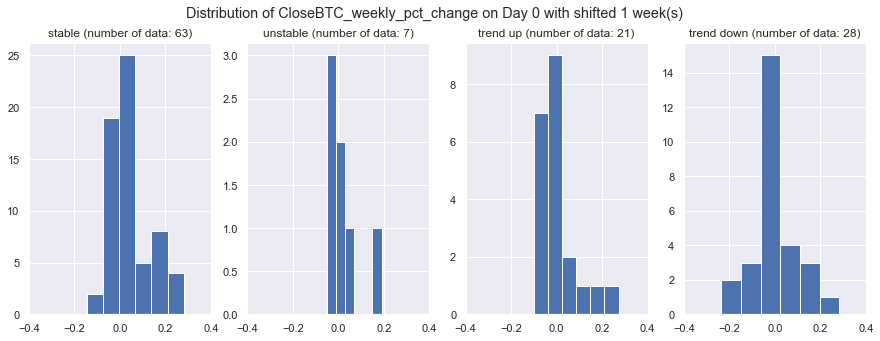

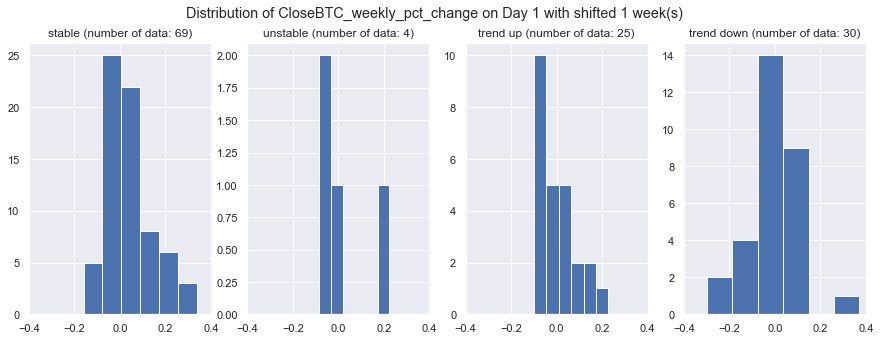

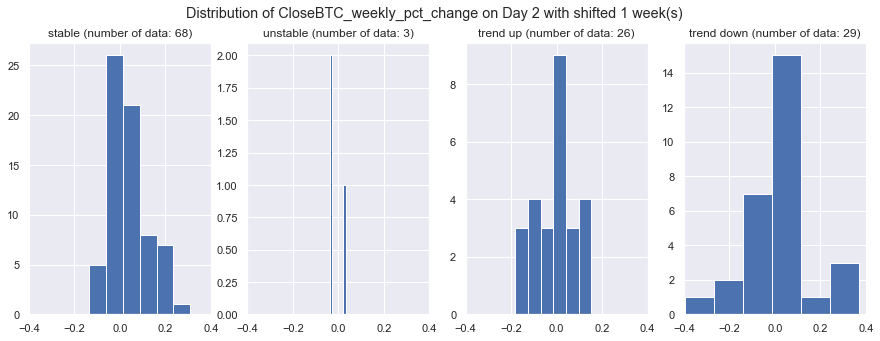

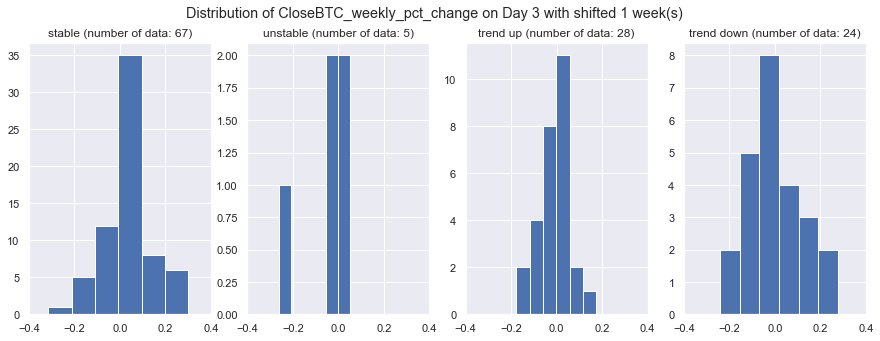

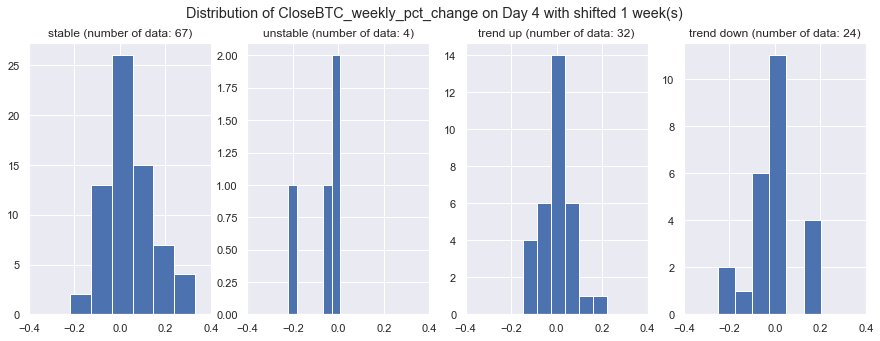

In [185]:
catagorised_data(t1, t2, t3, t4, 1, weekly_data, 'CloseBTC_weekly_pct_change', 'histogram', auto=True)

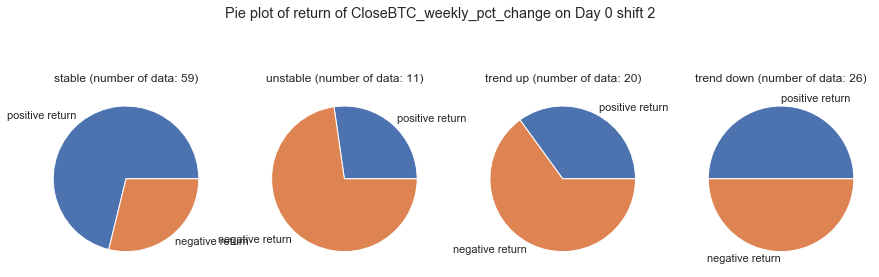

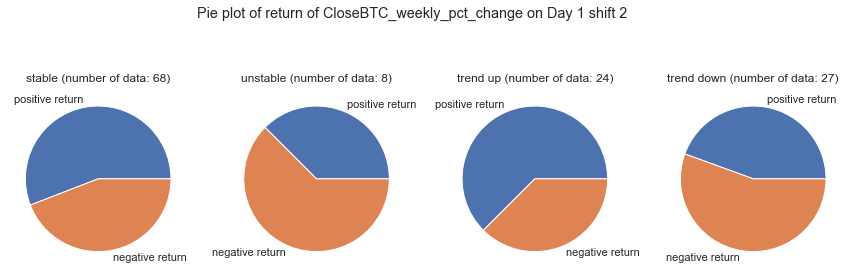

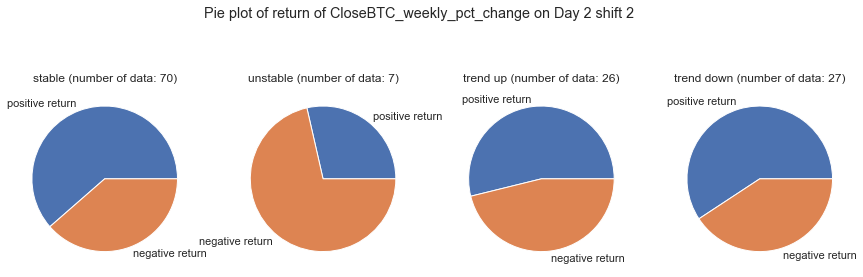

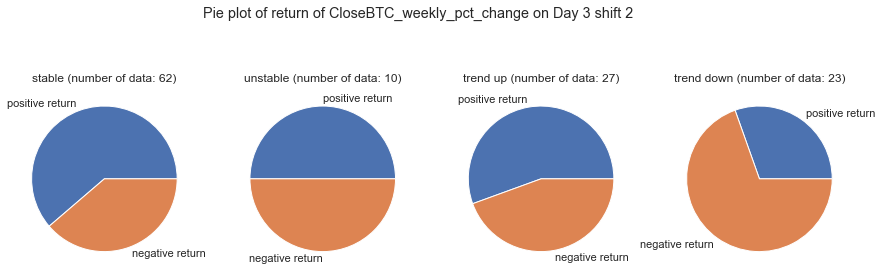

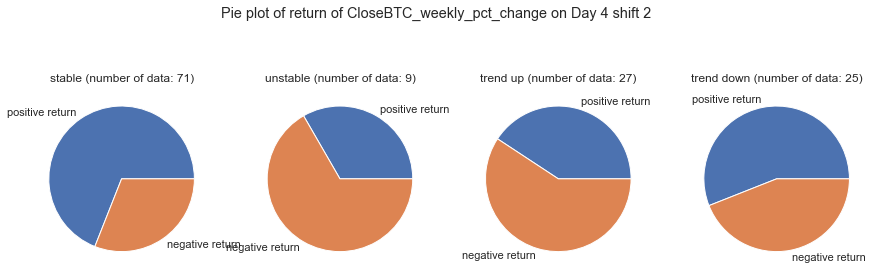

In [186]:
catagorised_data(t1, t2, t3, t4, 2, weekly_data, 'CloseBTC_weekly_pct_change', 'pie')

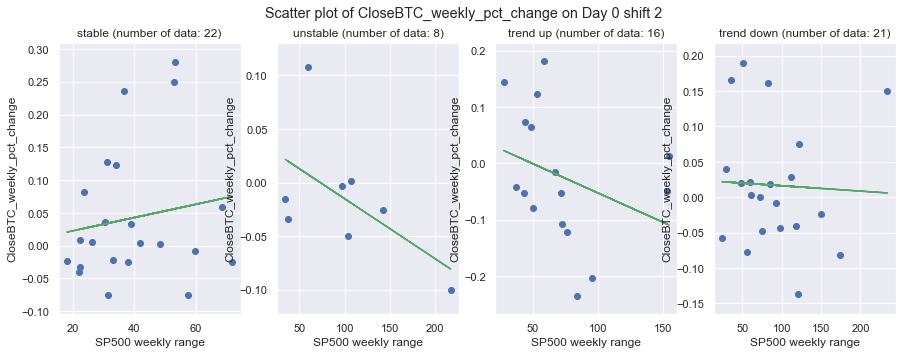

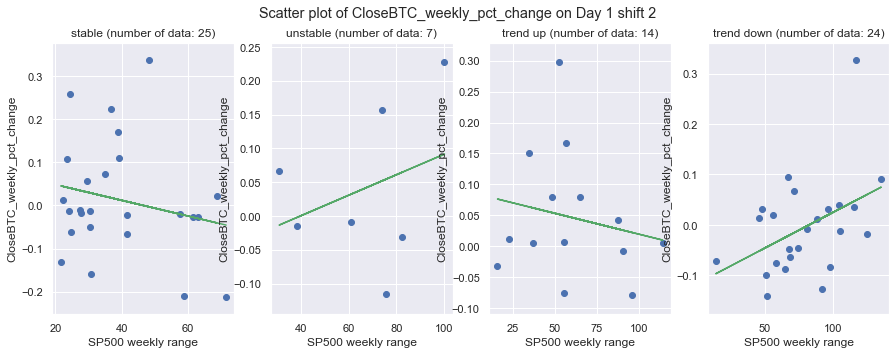

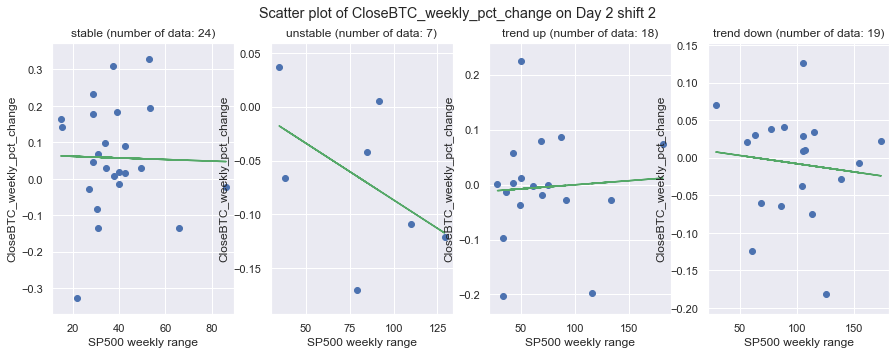

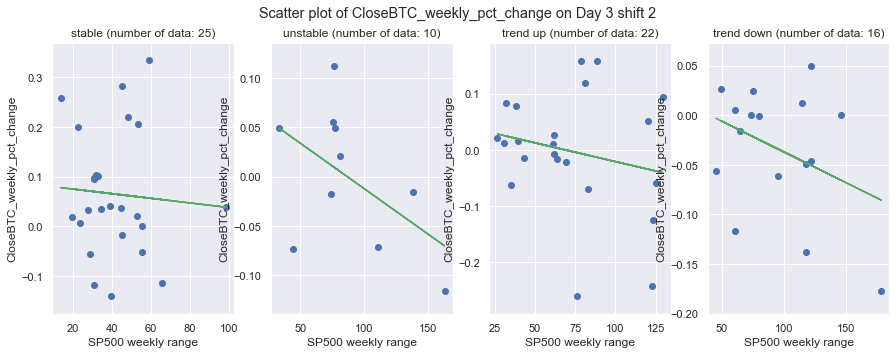

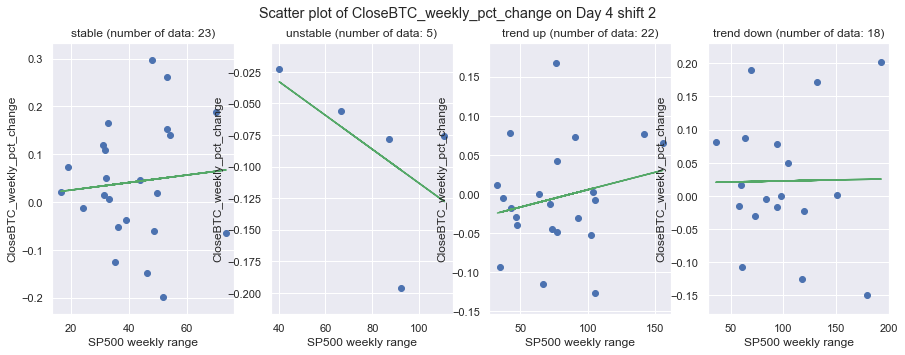

In [146]:
catagorised_data(t1, t2, t3, t4, 2, weekly_data, 'CloseBTC_weekly_pct_change', 'scatter_plot')